=== RAW REPORT ===
{'missing_columns': [], 'unexpected_columns': ['unexpected_col'], 'nulls_per_column': {'patient_id': 0, 'age': 0, 'sex': 0, 'date_enrolled': 0, 'height_cm': 7, 'weight_kg': 6}, 'duplicate_rows_on_patient_id': 10, 'enum_violations': {'sex': 5}, 'range_violations': {'age': 6, 'height_cm': 0, 'weight_kg': 0}} 

=== SUMMARY ===
{'missing_columns': 0, 'unexpected_columns': 1, 'total_nulls': 13, 'duplicate_rows_on_patient_id': 10, 'enum_violations_total': 5, 'range_violations_total': 6} 



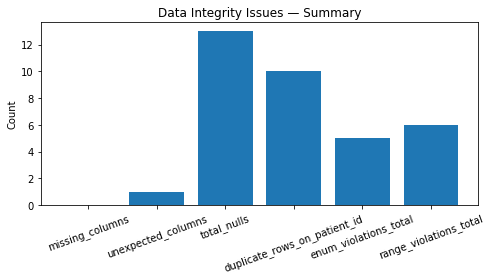

In [1]:
# Name: Data Integrity & Validation — Minimal Prototype
# Author: Rod Villalobos
# Purpose: Show an AI prototype performing data integrity & validation.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Create a small dataset with deliberate issues
np.random.seed(10)
N = 120
df = pd.DataFrame({
    "patient_id": np.arange(1, N+1),
    "age": np.random.choice(list(range(18, 90)) + [999, -3], size=N),
    "sex": np.random.choice(["M", "F", "?"], size=N, p=[0.48, 0.48, 0.04]),
    "date_enrolled": pd.to_datetime("2024-01-01") + pd.to_timedelta(np.random.randint(0, 365, size=N), unit="D"),
    "height_cm": np.random.normal(170, 12, size=N),
    "weight_kg": np.random.normal(75, 15, size=N),
})
# Inject nulls and duplicates
df.loc[np.random.choice(N, 6, replace=False), "height_cm"] = np.nan
df.loc[np.random.choice(N, 5, replace=False), "weight_kg"] = np.nan
dupes = df.sample(5, random_state=7)
df = pd.concat([df, dupes], ignore_index=True)
# Add an unexpected column
df["unexpected_col"] = np.random.randint(0, 3, size=len(df))

# 2) Validator
EXPECTED_COLUMNS = ["patient_id", "age", "sex", "date_enrolled", "height_cm", "weight_kg"]
ENUMS = {"sex": {"M", "F"}}
RANGES = {"age": (18, 90), "height_cm": (120.0, 220.0), "weight_kg": (35.0, 200.0)}

def validate(df: pd.DataFrame) -> dict:
    report = {}
    report["missing_columns"] = [c for c in EXPECTED_COLUMNS if c not in df.columns]
    report["unexpected_columns"] = [c for c in df.columns if c not in EXPECTED_COLUMNS]
    report["nulls_per_column"] = {c: int(df[c].isna().sum()) for c in EXPECTED_COLUMNS if c in df.columns}
    report["duplicate_rows_on_patient_id"] = int(df.duplicated(subset=["patient_id"], keep=False).sum())
    enum_viol = {col: int((~df[col].isin(allowed)).sum()) for col, allowed in ENUMS.items() if col in df.columns}
    range_viol = {
        col: int((df[col].notna() & ((df[col] < low) | (df[col] > high))).sum())
        for col, (low, high) in RANGES.items() if col in df.columns
    }
    report["enum_violations"], report["range_violations"] = enum_viol, range_viol
    return report

report = validate(df)

# 3) Summarize results
summary = {
    "missing_columns": len(report["missing_columns"]),
    "unexpected_columns": len(report["unexpected_columns"]),
    "total_nulls": sum(report["nulls_per_column"].values()),
    "duplicate_rows_on_patient_id": report["duplicate_rows_on_patient_id"],
    "enum_violations_total": sum(report["enum_violations"].values()),
    "range_violations_total": sum(report["range_violations"].values()),
}

# 4) Display results
print("=== RAW REPORT ===")
print(report, "\n")
print("=== SUMMARY ===")
print(summary, "\n")

# 5) Visualize issues
plt.figure(figsize=(7,4))
plt.bar(summary.keys(), summary.values())
plt.title("Data Integrity Issues — Summary")
plt.ylabel("Count")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


